In [1]:
import os
import numpy as np
from scipy import spatial as sspat
import pandas as pd
import matplotlib.pyplot as plt

/Users/ivasenkov15/miniconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
EPS = 1e-6


def calculate_relative_L1_error(nodes1 :np.ndarray, values1 :np.ndarray, nodes2 :np.ndarray, values2 :np.ndarray):
    """
    
    1. Map mesh nodes1 -> mesh nodes2 (Nearest Neighbor)
    2. Denominator = MAX(|Vc|, |Vf|)
    3. Metric = Sum( |Diff| / Denom ) / N_nodes1
    """
    if nodes1 is None or nodes2 is None:
        return 0.0

    n = values1.shape[0] * values1.shape[1]
    
    # Map nodes1 to nodes2
    tree = sspat.cKDTree(nodes2)
    dists, idx = tree.query(nodes1, k=1)
    values2_mapped = values2[idx]

    # Denominator: Max of absolute values
    denominator = np.abs(values1) + np.abs(values2_mapped)
    
    # Numerator: Absolute Difference
    diff = np.abs(values1 - values2_mapped)
    
    # Filter valid comparisons
    mask = denominator > EPS
    
    if np.sum(mask) == 0:
        return 0.0
        
    # Sum of Relative Differences
    valid_terms = diff[mask] / denominator[mask]
    sum_diff = np.sum(valid_terms)
    
    # Normalize by N
    return sum_diff / n

In [3]:
BASE_FOLDER = 'testcases'


def get_test_folders(base_folder=BASE_FOLDER):
    for _, next_folders, _ in os.walk(base_folder):
        return list(map(lambda x: f'{base_folder}/{x}', filter(lambda x: x.startswith('test'), next_folders)))
    return None


def get_test_filename(folder, label):
    for _, _, filenames in os.walk(folder):
        for filename in filenames:
            if label in filename:
                return f'{folder}/{filename}'
    return None


def read_data(filename, coord_cols, vals_cols):
    ds = pd.read_csv(filename)
    return np.asarray(ds[coord_cols]), np.asarray(ds[vals_cols])


def get_relative_error(test_folder, coord_cols, ansys_val_cols, matlab_vals_cols, matlab_label, ansys_label):
    matlab_filename = get_test_filename(test_folder, matlab_label)
    ansys_filename = get_test_filename(test_folder, ansys_label)
    if matlab_filename is None or ansys_filename is None:
        return None

    matlab_nodes, matlab_values = read_data(matlab_filename, coord_cols, matlab_vals_cols)
    ansys_nodes, ansys_values = read_data(ansys_filename, coord_cols, ansys_val_cols)
    return calculate_relative_L1_error(matlab_nodes, matlab_values, ansys_nodes, ansys_values)

In [4]:
DEFAULT_COORD_COLS = ['X', 'Y', 'Z']
DEFAULT_DISPL_VALS_COLS = ['u_x', 'u_y', 'u_z']
TESTCASES = [
    (
        'Displacement',
         [
            ('Displacement: mesh_size = 0.02', 0.02, 'MATLAB_0.02', 'ANSYS_0.02', DEFAULT_COORD_COLS, DEFAULT_DISPL_VALS_COLS, DEFAULT_DISPL_VALS_COLS),
            ('Displacement: mesh_size = 0.015', 0.015, 'MATLAB_0.015', 'ANSYS_0.015', DEFAULT_COORD_COLS, DEFAULT_DISPL_VALS_COLS, DEFAULT_DISPL_VALS_COLS),
            ('Displacement: mesh_size = 0.01', 0.01, 'MATLAB_0.01', 'ANSYS_0.01', DEFAULT_COORD_COLS, DEFAULT_DISPL_VALS_COLS, DEFAULT_DISPL_VALS_COLS),
            ('Displacement: mesh_size = 0.007', 0.007, 'MATLAB_0.007', 'ANSYS_0.007', DEFAULT_COORD_COLS, DEFAULT_DISPL_VALS_COLS, DEFAULT_DISPL_VALS_COLS),
            ('Displacement: mesh_size = 0.006', 0.006, 'MATLAB_0.006', 'ANSYS_0.006', DEFAULT_COORD_COLS, DEFAULT_DISPL_VALS_COLS, DEFAULT_DISPL_VALS_COLS),
            ('Displacement: mesh_size = 0.005', 0.005, 'MATLAB_0.005', 'ANSYS_0.005', DEFAULT_COORD_COLS, DEFAULT_DISPL_VALS_COLS, DEFAULT_DISPL_VALS_COLS),
            ('Displacement: mesh_size = 0.004', 0.004, 'MATLAB_0.004', 'ANSYS_0.004', DEFAULT_COORD_COLS, DEFAULT_DISPL_VALS_COLS, DEFAULT_DISPL_VALS_COLS),
        ],
    ),
]

testcases/test_naca0012:
    Displacement: mesh_size = 0.02: 0.012278
    Displacement: mesh_size = 0.015: 0.011806
    Displacement: mesh_size = 0.01: 0.013562
    Displacement: mesh_size = 0.007: 0.005744
    Displacement: mesh_size = 0.006: 0.005100
    Displacement: mesh_size = 0.005: 0.004738
    Displacement: mesh_size = 0.004: 0.003484

testcases/test_naca0015:
    Displacement: mesh_size = 0.02: 0.004103
    Displacement: mesh_size = 0.015: 0.004679
    Displacement: mesh_size = 0.01: 0.004179
    Displacement: mesh_size = 0.007: 0.002652
    Displacement: mesh_size = 0.006: 0.002227
    Displacement: mesh_size = 0.005: 0.002263
    Displacement: mesh_size = 0.004: None

testcases/test_naca1234:
    Displacement: mesh_size = 0.02: 0.003500
    Displacement: mesh_size = 0.015: 0.003132
    Displacement: mesh_size = 0.01: 0.002424
    Displacement: mesh_size = 0.007: 0.001527
    Displacement: mesh_size = 0.006: 0.001332
    Displacement: mesh_size = 0.005: None
    Displacement:

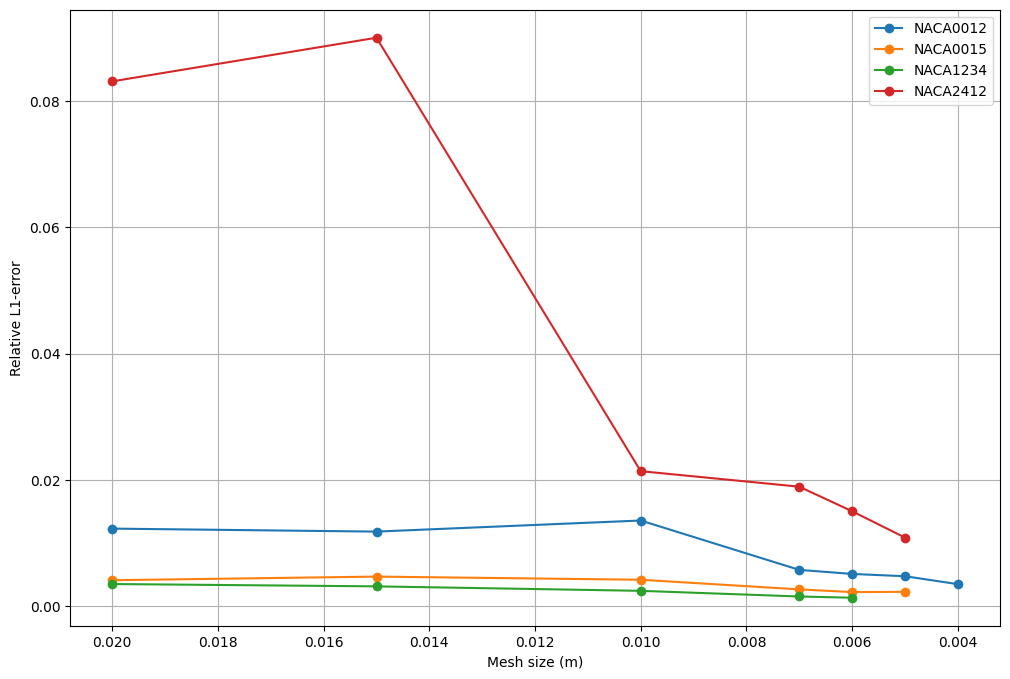

In [16]:
labels_to_result = dict()

for test_folder in get_test_folders():
    print(f'{test_folder}:')
    label = f'NACA{test_folder[-4:].upper()}'
    grid_sizes = []
    errors = []
    for test_block_name, test_block in TESTCASES:
        for test_name, grid_size, matlab_label, ansys_label, coord_cols, ansys_val_cols, matlab_vals_cols in test_block:
            rel_err = get_relative_error(test_folder, coord_cols, ansys_val_cols, matlab_vals_cols, matlab_label, ansys_label)
            prefix = f'    {test_name}'
            if rel_err is not None:
                print(f'{prefix}: {rel_err:.6f}')
                grid_sizes.append(grid_size)
                errors.append(rel_err)
            else:
                print(f'{prefix}: None')
    labels_to_result[label] = (grid_sizes, errors)
    print()

fig = plt.figure(figsize=(12, 8))
for label, (grid_sizes, errors) in labels_to_result.items():
    plt.plot(grid_sizes, errors, marker='o', label=label)
fig.get_axes()[0].invert_xaxis()
plt.ylabel('Relative L1-error')
plt.xlabel('Mesh size (m)')
plt.legend()
plt.grid()
plt.show()